In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['competitive-data-science-predict-future-sales', 'sales1-grid-itmcat-target-meanenc-lag']


In [2]:
import gc
from tqdm import tqdm_notebook
from math import ceil
import pickle

from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [3]:
#all_data = pd.read_pickle('../input/all_data.gzip')
#all_data.head()

In [4]:
drop_cols = ['item_category_id', 'type_id', 'subtype_id', 'city_id',
            'target_item_lag_3', 'target_item_lag_5',
            'target_item_cat_lag_3', 'target_item_cat_lag_4', 'target_item_cat_lag_5', 'target_item_cat_lag_6',
            'target_item_type_lag_6',
            'target_item_subtype_lag_4', 'target_item_subtype_lag_6',
            'target_city_lag_3', 'target_city_lag_4', 'target_city_lag_5',
            'delta_avg_item_price_lag_2', 'delta_avg_item_price_lag_4',
            'delta_avg_shop_revenue_lag_3', 'delta_avg_shop_revenue_lag_6']

#for i in range(1,7):
#    drop_cols += ['target_item_type_lag_' + str(i),
#                      'target_item_subtype_lag_' + str(i),
#                      'target_city_lag_' + str(i),
#                      'delta_avg_item_price_lag_' + str(i),
#                      'delta_avg_shop_revenue_lag_' + str(i)]

X_train = pd.read_pickle('../input/sales1-grid-itmcat-target-meanenc-lag/X_train.gzip').drop(drop_cols, axis=1)
X_val = pd.read_pickle('../input/sales1-grid-itmcat-target-meanenc-lag/X_val.gzip').drop(drop_cols, axis=1)
y_train = np.load('../input/sales1-grid-itmcat-target-meanenc-lag/y_train.gzip', allow_pickle=True)
y_val = np.load('../input/sales1-grid-itmcat-target-meanenc-lag/y_val.gzip', allow_pickle=True)

test = pd.read_pickle('../input/sales1-grid-itmcat-target-meanenc-lag/test.gzip').drop(drop_cols, axis=1)

In [5]:
X_train.shape, X_val.shape, len(y_train), len(y_val), test.shape

((6186922, 46), (238172, 46), 6186922, 238172, (214200, 46))

In [6]:
test.head()

,shop_id,item_id,item_target_enc,shop_target_enc,item_category_target_enc,type_target_enc,subtype_target_enc,city_target_enc,target_lag_1,target_shop_lag_1,target_item_lag_1,target_item_cat_lag_1,target_item_type_lag_1,target_item_subtype_lag_1,target_city_lag_1,delta_avg_item_price_lag_1,delta_avg_shop_revenue_lag_1,target_lag_2,target_shop_lag_2,target_item_lag_2,target_item_cat_lag_2,target_item_type_lag_2,target_item_subtype_lag_2,target_city_lag_2,delta_avg_shop_revenue_lag_2,target_lag_3,target_shop_lag_3,target_item_type_lag_3,target_item_subtype_lag_3,delta_avg_item_price_lag_3,target_lag_4,target_shop_lag_4,target_item_lag_4,target_item_type_lag_4,delta_avg_shop_revenue_lag_4,target_lag_5,target_shop_lag_5,target_item_type_lag_5,target_item_subtype_lag_5,delta_avg_item_price_lag_5,delta_avg_shop_revenue_lag_5,target_lag_6,target_shop_lag_6,target_item_lag_6,target_city_lag_6,delta_avg_item_price_lag_6
0,5,5037,1.951172,0.189331,0.757324,0.711914,0.700684,0.189331,0.0,1052.0,25.0,2444.0,13104.0,2532.0,1052.0,-0.222046,-0.101013,1.0,1092.0,110.0,3980.0,16416.0,4074.0,1092.0,-0.042847,3.0,1294.0,14904.0,4808.0,-0.535645,1.0,991.0,54.0,11680.0,-0.325684,1.0,954.0,13072.0,3616.0,-0.302979,-0.293213,1.0,1012.0,87.0,1012.0,-0.199219
1,5,5320,0.333984,0.189331,0.224121,0.172729,0.224121,0.189331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,5,5233,1.657227,0.189331,0.757324,0.711914,0.700684,0.189331,1.0,1052.0,42.0,2444.0,13104.0,2532.0,1052.0,0.497314,-0.101013,3.0,1092.0,80.0,3980.0,16416.0,4074.0,1092.0,-0.042847,1.0,1294.0,14904.0,4808.0,-0.110657,0.0,991.0,37.0,11680.0,-0.325684,2.0,954.0,13072.0,3616.0,-0.187134,-0.293213,3.0,1012.0,71.0,1012.0,-0.013412
3,5,5232,1.092773,0.189331,0.666016,0.711914,0.644531,0.189331,0.0,1052.0,28.0,2204.0,13104.0,2488.0,1052.0,0.505859,-0.101013,0.0,1092.0,48.0,3590.0,16416.0,3888.0,1092.0,-0.042847,1.0,1294.0,14904.0,3978.0,-0.187256,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,5,5268,0.333984,0.189331,1.911133,0.711914,1.838867,0.189331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


# ExtraTreesRegressor:

In [7]:
%%time
#model = ExtraTreesRegressor(criterion='mse', verbose=1)

#model.fit(X_train, y_train)

#model.score(X_test, y_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


# XGBoost:

## Iterative Increment training:

In [8]:
#len(X_train)/2

%%time
batch_size = int(len(X_train) / 2)
iterations = 10
model = None
rmse_train_list = list()
rmse_val_list = list()

for i in tqdm_notebook(range(iterations)):
    for start in tqdm_notebook(range(0, len(X_train), batch_size)):
        model = xgb.train({
            'max_depth' : 8,
            'learning_rate': 0.1,
            'seed' : 4,
            'eval_metric' : 'rmse',
            'min_child_weight' : 300,
            'sub_sample' : 0.8,
            'colsample_bytree' : 0.8
            #'verbosity' : 3
            #'predictor' : 'gpu_predictor'
        }, dtrain=xgb.DMatrix(X_train[start:start+batch_size], y_train[start:start+batch_size]), xgb_model=model)
        
    y_train_pr = model.predict(xgb.DMatrix(X_train))
    y_val_pr = model.predict(xgb.DMatrix(X_val))
    
    rmse_train_list.append(mse(y_train, y_train_pr) ** (1/2))
    rmse_val_list.append(mse(y_val, y_val_pr) ** (1/2))
    
    print('Train RMSE itr@{}: {}'.format(i, rmse_train_list[i]))
    print('Val RMSE itr@{}: {}'.format(i, rmse_val_list[i]))

    # plot the rmse
    plt.plot(rmse_train_list, label='train')
    plt.plot(rmse_val_list, label='val')
        
        
    #print('RMSE itr@{}: {}'.format(i, mse(y_val, y_pr) ** (1/2)))

y_pred = model.predict(xgb.DMatrix(X_val))
print('RMSE at the end: {}'.format(mse(y_val, y_pred) ** (1/2)))

In [9]:
#rmse_train_list, rmse_val_list

## Model fitting:

In [10]:
%%time
model = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300, 
                     colsample_bytree=0.8, subsample=0.8, eta=0.3, seed=4)

model.fit(X_train, y_train, eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmse:3.39664	validation_1-rmse:2.61129
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.30564	validation_1-rmse:2.52801
[2]	validation_0-rmse:3.23569	validation_1-rmse:2.458
[3]	validation_0-rmse:3.16746	validation_1-rmse:2.39972
[4]	validation_0-rmse:3.10972	validation_1-rmse:2.34883
[5]	validation_0-rmse:3.06289	validation_1-rmse:2.30308
[6]	validation_0-rmse:3.02052	validation_1-rmse:2.26519
[7]	validation_0-rmse:2.9879	validation_1-rmse:2.23895
[8]	validation_0-rmse:2.95463	validation_1-rmse:2.21042
[9]	validation_0-rmse:2.92592	validation_1-rmse:2.18681
[10]	validation_0-rmse:2.90136	validation_1-rmse:2.16911
[11]	validation_0-rmse:2.88053	validation_1-rmse:2.15622
[12]	validation_0-rmse:2.8624	validation_1-rmse:2.14257
[13]	validation_0-rmse:2.84349	validation_1-rmse:2.12591
[14]	validation_0-rmse:2.82849	validation_1-rmse:2.11637


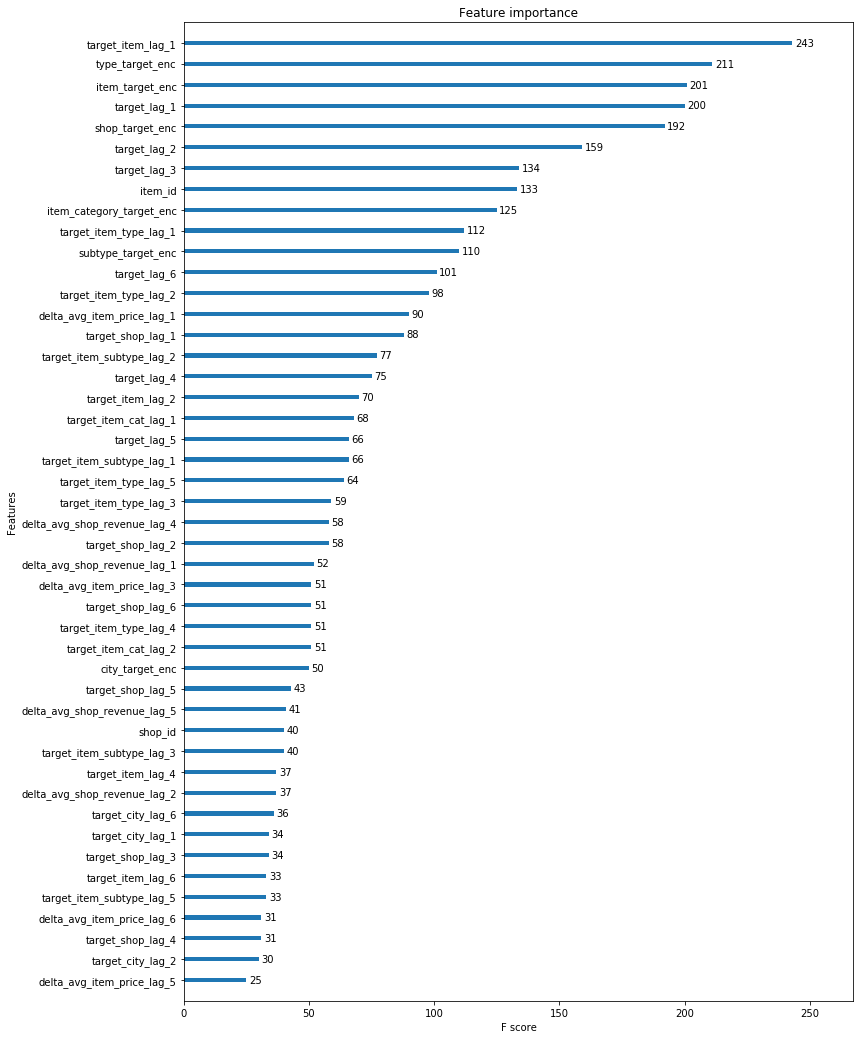

In [11]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, ax=ax, grid=False)

In [12]:
#test = pd.read_csv('../input/test.csv', index_col=0)
#test.drop(['ID'], axis=1).head()

In [13]:
sub = model.predict(test)
sub = sub.clip(0, 20)
sub[:5]

array([0.503349  , 0.24781942, 1.0695819 , 0.37043342, 4.3003254 ],
      dtype=float32)

In [14]:
# pickle model
pickle.dump(model, open("xgbmodel.dat", "wb"))

In [15]:
sub = pd.DataFrame(sub, columns=['item_cnt_month'])
sub.head()

,item_cnt_month
0,0.503349
1,0.247819
2,1.069582
3,0.370433
4,4.300325


In [16]:
sub.to_csv('sub.csv', index_label='ID')
pd.read_csv('sub.csv').head()

,ID,item_cnt_month
0,0,0.503349
1,1,0.247819
2,2,1.069582
3,3,0.370433
4,4,4.300325
